<a href="https://colab.research.google.com/github/jjschueder/7331DataMiningNotebooks/blob/master/lab1/LAB01-DataMining-Joe%20Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

 ### Team:  
Joseph Schueder,
Armando Vela,
Daniel Clark,
Jeff Washburn

### Load Python Packages

In [1]:
# Import necessary python packages
try:
    from collections import abc as collections_abc
except ImportError:  # Python 2.7
    import collections as collections_abc

    import copy
import functools
import gzip
import io
import itertools
import json
import math
import os
import tempfile
import uuid
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import numpy as np
#import altair as alt
import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

# Imports the Google Cloud client library
#from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import bigquery

### Load Data from github

We will be querying the 2019 data and subsetting a random sample of 400,000 rows within the 2 million sales that happened that year for our analysis

In [2]:
# Read csv from disk
#df =  pd.read_csv(r'/Users/jjschued/Documents/Github/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 100000)
#df =  pd.read_csv(r'/Users/danielclark/Desktop/SMU/data_mining/7331DataMiningNotebooks/lab1/iowa_subset_2019_400k_random_rows.csv', nrows = 50000)

#df =  pd.read_csv(r'/Users/jjsch/Documents/Github/7331lab1/7331DataMiningNotebooks/Live Assignment 1/cleandataframe.csv',sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
#dfencoded =  pd.read_csv(r'/Users/jjsch/Documents/Github/7331lab1/7331DataMiningNotebooks/Live Assignment 1/df1hotmerge2.csv',sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

# read csv from github directly
url_dataset = 'https://github.com/jjschueder/7331DataMiningNotebooks/blob/master/Live%20Assignment%201/df1hotmerge2.csv?raw=true'
#df = pd.read_csv(url_dataset, nrows=50000)
dfencoded = pd.read_csv(url_dataset)

# verify data read in
dfencoded.head(5)

NameError: name 'df' is not defined

### Columns and Descriptions
Below are the 24 columns found in the data set along with description of each.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 37 columns):
Unnamed: 0                  400000 non-null object
invoice_and_item_number     400000 non-null object
date                        400000 non-null object
store_number                400000 non-null object
store_name                  400000 non-null object
address                     400000 non-null object
city                        400000 non-null object
zip_code                    400000 non-null object
store_location              400000 non-null object
county_number               400000 non-null object
county                      400000 non-null object
category                    400000 non-null object
category_name               400000 non-null object
vendor_number               400000 non-null object
vendor_name                 400000 non-null object
item_number                 400000 non-null object
item_description            400000 non-null object
pack                  

Detailed Description of each field - referenced from the [data.iowa.gov](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy) site that describes the dataset

*   invoice_and_item_number (text) - Invoice and item associated with the liquor order.  This is unique identifier 
*   date (date) - Date of when the order was placed
*   store_number (int) - Unique number assigned to the retail store that placed the order
*   store_name (text) - Name of the retail store that placed the order
*   address (text) - Address of the retail store that placed the order
*   city (text) - City of the retail store that placed the order
*   zip_code (float) - Zip code of the retail store that placed the order
*   store_location (text) - Lat/Long of retail store that placed the order
*   county_number (float) - Iowa county number for which the retail store that placed the order resides
*   county (text) - County name for which the retail store is located that placed the order
*   category (float) - Category code for the liquor that was ordered
*   category_name (text) - Category of the liquor that was ordered
*   vendor_number (int) - The vendor number of the company for the brand of liquor ordered 
*   vendor_name (text) - The vendor name of the company for the brand of liquor ordered
*   item_number (int) - Item number for individual liquor product ordered
*   item_description (text) - Description of the liquor item ordered
*   pack (int) - The number of bottles in a case for the liquor ordered
*   bottle_volume_ml (int) - Volume of each liquor bottle ordered in milliliters
*   state_bottle_cost (float) - The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered
*   state_bottle_retail (float) - The amount the store paid for each bottle of liquor ordered
*   bottles_sold (int) - Number of bottles of liquor ordered by the retail store
*   sale_dollars (float) - Total cost of liquor ordered (bottles_sold * state_bottle_retail)
*   volume_sold_liters (float) - Total volume of liquor ordered in liters (bottle_volume_ml * bottles_sold / 1000)
*   volume_sold_gallons (float) - Total volume of liquor ordered in gallons (bottle_volume_ml * bottles_sold / 3785.411784)





## Data Quality  
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

Running a df.columns.values function, confirms the 24 features that we referenced in our Data understanding phase. This now allows us to move forward with our data cleaning. 

In [13]:
df.columns.values

array(['Unnamed: 0', 'invoice_and_item_number', 'date', 'store_number',
       'store_name', 'address', 'city', 'zip_code', 'store_location',
       'county_number', 'county', 'category', 'category_name',
       'vendor_number', 'vendor_name', 'item_number', 'item_description',
       'pack', 'bottle_volume_ml', 'state_bottle_cost',
       'state_bottle_retail', 'bottles_sold', 'sale_dollars',
       'volume_sold_liters', 'volume_sold_gallons', 'liquor_category',
       'store_parent', 'month', 'year', 'monthyear', 'sale_dollars_trans',
       'cost_per_liter', 'cost_per_liter_trans',
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'grossmargin'], dtype=object)

In [14]:
# replace '?' with -1, we will deal with missing values later
df = df.replace(to_replace='?',value=-1) 

categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
                        'monthyear', 'liquor_category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 
                       'volume_sold_gallons', 'bottles_sold', 'sale_dollars_trans', 'cost_per_liter',    
                        'cost_per_liter_trans', 'state_bottle_cost_trans', 'bottles_sold_trans',
                       'volume_sold_liters_trans', 'grossmargin']

# and the oridnal values to be integers
ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)
df[categorical_features] = df[categorical_features].astype(object)
df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 37 columns):
Unnamed: 0                  400000 non-null object
invoice_and_item_number     400000 non-null object
date                        400000 non-null object
store_number                400000 non-null object
store_name                  400000 non-null object
address                     400000 non-null object
city                        400000 non-null object
zip_code                    400000 non-null object
store_location              400000 non-null object
county_number               400000 non-null object
county                      400000 non-null object
category                    400000 non-null object
category_name               400000 non-null object
vendor_number               400000 non-null object
vendor_name                 400000 non-null object
item_number                 400000 non-null object
item_description            400000 non-null object
pack                  

The following will do some cleanup on values and categorize store, category, and dates into more summarized values

In [15]:
df_corr = df.copy()

In [16]:
df_corr.head()

,Unnamed: 0,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,...,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241.0,POINT (-91.565517 41.672672),52.0,...,Nov,2019,Nov-2019,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317.0,POINT (-93.570489 41.607817),77.0,...,Nov,2019,Nov-2019,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302.0,blank,57.0,...,May,2019,May-2019,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807.0,POINT (-90.548919 41.55678100000001),82.0,...,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503.0,POINT (-95.825137 41.242732),78.0,...,Nov,2019,Nov-2019,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


In [17]:

# Create correlation matrix
corr_matrix = df_corr.corr().abs()
corr_matrix

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
pack,1.000000,0.583376,0.396909,0.396613,0.197974,0.044329,0.045399,0.045420,0.149088,0.111411,0.031250,0.659579,0.285858,0.097873,0.029256
bottle_volume_ml,0.583376,1.000000,0.257163,0.256866,0.050324,0.070925,0.116995,0.117054,0.244269,0.282219,0.487253,0.406372,0.026219,0.490400,0.015925
state_bottle_cost,0.396909,0.257163,1.000000,0.998987,0.094551,0.093317,0.008615,0.008617,0.274887,0.298577,0.491705,0.824341,0.269951,0.085615,0.021261
state_bottle_retail,0.396613,0.256866,0.998987,1.000000,0.094477,0.093215,0.008620,0.008622,0.274663,0.298243,0.491232,0.823560,0.269661,0.085501,0.005495
bottles_sold,0.197974,0.050324,0.094551,0.094477,1.000000,0.806402,0.852826,0.852826,0.419954,0.048674,0.083678,0.172085,0.526076,0.380934,0.004968
sale_dollars,0.044329,0.070925,0.093317,0.093215,0.806402,1.000000,0.859482,0.859482,0.474039,0.013155,0.017666,0.109463,0.394611,0.361270,0.002498
volume_sold_liters,0.045399,0.116995,0.008615,0.008620,0.852826,0.859482,1.000000,1.000000,0.371699,0.047608,0.098178,0.007940,0.360519,0.351944,0.000039
volume_sold_gallons,0.045420,0.117054,0.008617,0.008622,0.852826,0.859482,1.000000,1.000000,0.371718,0.047615,0.098212,0.007950,0.360531,0.351980,0.000039
sale_dollars_trans,0.149088,0.244269,0.274887,0.274663,0.419954,0.474039,0.371699,0.371718,1.000000,0.042377,0.008465,0.308425,0.781589,0.790142,0.006441
cost_per_liter,0.111411,0.282219,0.298577,0.298243,0.048674,0.013155,0.047608,0.047615,0.042377,1.000000,0.691285,0.220768,0.186546,0.456984,0.006487


In [19]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# courtesy of https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

In [20]:
to_drop

['state_bottle_retail', 'volume_sold_gallons']

Looking at our correlation matrix, we can see which measures meet our criteria of removing features that have a greater than 95% correlation. As the predictability of one feature will determine another, which will cause us to want to do a dimensionality reduction. 
In our case, we are going to remove state_bottle_retail as it correlates highly with state_bottle_cost, as well as volume_sold_gallons as it correlates perfectly with volume_sold_liters.

In [21]:
# Drop features 
df_corr = df_corr.drop(df_corr[to_drop], axis=1)

### Feature Reduction using PCA and LDA
PCA  
To run a PCA analysis, we will want to first remove some of the highly correlated variables which may throw off our analysis. This will mean we should run a correlation plot and set our correlation threshold to 0.95, which we will remove variables if exceeded. 

First, lets take a look at our Seaborn plot that we will use to run principal component analysis. To get started, we will want to create dummies for each of our categories of alcohol, so that we have a single binary under Whiskey as the sale was a whiskey drink (1) or it was not (0)

In [22]:
df_corr2 = pd.get_dummies(df['liquor_category'], drop_first=False)
df_corr = pd.concat([df_corr, df_corr2], axis = 1, sort=False)

In [78]:
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#drop the response variable from x
# one hot encoding to category
features = ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold', 'sale_dollars_trans', 'volume_sold_liters', 
            'cost_per_liter', 'sale_dollars_trans', 'cost_per_liter', 'cost_per_liter_trans', 'state_bottle_cost_trans',
            'bottles_sold_trans', 'volume_sold_liters_trans','grossmargin']

X = df_corr.loc[:, features].values
# run this second line below which compiles all the features that i want to use to predict category, or the column we want to predict
#X = X.drop (category, inplace = True)
y = df_corr.loc[:, ['WHISKY']].values
#target_names = df_corr.store_parent_names

pca = PCA(n_components=4)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=4)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components
y
print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

C:\Users\jjsch\.conda\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jjsch\.conda\envs\ML7331\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(14, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
C:\Users\jjsch\.conda\envs\ML7331\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


pca: [[-8.70077008e-03  9.98090511e-01  3.67444888e-03 -3.32222253e-03
   4.63659686e-04  9.73632831e-03 -4.25301876e-02  4.63659686e-04
  -4.25301876e-02 -7.32630520e-04  5.09388931e-04 -4.57411382e-05
   1.19629021e-03 -9.16561295e-08]
 [-2.27046216e-02  5.98046097e-02  2.90546311e-02 -2.75582492e-02
   2.43614451e-04 -1.12634896e-02  7.05029190e-01  2.43614451e-04
   7.05029190e-01  4.32821647e-03  2.30478946e-03 -2.06144008e-03
  -4.08460202e-03 -3.46537458e-07]
 [ 1.02584481e-02 -3.84730183e-03 -5.55584771e-03  6.22850676e-01
   7.29217124e-03  7.81636560e-01  1.88950806e-02  7.29217124e-03
   1.88950806e-02 -6.00482854e-04 -8.69942951e-04  8.16138339e-03
   7.89265409e-03  1.34022228e-07]
 [-1.69510318e-01 -1.12826276e-02  3.99089307e-02 -7.67545642e-01
  -1.29702715e-02  6.15401924e-01 -1.32736729e-02 -1.29702715e-02
  -1.32736729e-02  5.20022440e-03  1.04034411e-02 -2.33690831e-02
  -1.81704959e-02 -1.09287573e-06]]
lda: [[ 0.0100546  -0.00145164  0.09452347  0.00356501  0.1976

In [28]:
df.columns.values

array(['Unnamed: 0', 'invoice_and_item_number', 'date', 'store_number',
       'store_name', 'address', 'city', 'zip_code', 'store_location',
       'county_number', 'county', 'category', 'category_name',
       'vendor_number', 'vendor_name', 'item_number', 'item_description',
       'pack', 'bottle_volume_ml', 'state_bottle_cost',
       'state_bottle_retail', 'bottles_sold', 'sale_dollars',
       'volume_sold_liters', 'volume_sold_gallons', 'liquor_category',
       'store_parent', 'month', 'year', 'monthyear', 'sale_dollars_trans',
       'cost_per_liter', 'cost_per_liter_trans',
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'grossmargin'], dtype=object)

In [71]:
# this function definition just formats the weights into readable strings
# you can skip it without loss of generality to the Data Science content
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array
  
# now let's get to the Data Analytics!
pca_weight_strings = get_feature_names_from_weights(pca.components_, features) 
lda_weight_strings = get_feature_names_from_weights(lda.scalings_.T, features) 

# create some pandas dataframes from the transformed outputs
df_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])
df_lda = pd.DataFrame(X_lda,columns=[lda_weight_strings])

df_pca.head()

#from pandas.plotting import scatter_plot

ax = df_pca.plot.scatter(pca_weight_strings[0], pca_weight_strings[1], c=y.reshape(150,-1), s=(y+2)*10)
newfig = plt.figure()
ax = df_lda.plot.scatter(lda_weight_strings[0], lda_weight_strings[1], c=y.reshape(150,-1), s=(y+2)*10)
plt.show()

ValueError: cannot reshape array of size 400000 into shape (150,newaxis)

In [57]:
pca_weight_strings

['-0.01* +1.00*bottle_volu +0.00*state_bottle -0.00*bottles +0.00*sale_dollars_ +0.01*volume_sold_l -0.04*cost_per_ +0.00*sale_dollars_ -0.04*cost_per_ -0.00*cost_per_liter_ +0.00*state_bottle_cost_ -0.00*bottles_sold_ +0.00*volume_sold_liters_ -0.00*grossm ',
 '-0.02* +0.06*bottle_volu +0.03*state_bottle -0.03*bottles +0.00*sale_dollars_ -0.01*volume_sold_l +0.71*cost_per_ +0.00*sale_dollars_ +0.71*cost_per_ +0.00*cost_per_liter_ +0.00*state_bottle_cost_ -0.00*bottles_sold_ -0.00*volume_sold_liters_ -0.00*grossm ',
 '0.01* -0.00*bottle_volu -0.01*state_bottle +0.62*bottles +0.01*sale_dollars_ +0.78*volume_sold_l +0.02*cost_per_ +0.01*sale_dollars_ +0.02*cost_per_ -0.00*cost_per_liter_ -0.00*state_bottle_cost_ +0.01*bottles_sold_ +0.01*volume_sold_liters_ +0.00*grossm ',
 '-0.17* -0.01*bottle_volu +0.04*state_bottle -0.77*bottles -0.01*sale_dollars_ +0.62*volume_sold_l -0.01*cost_per_ -0.01*sale_dollars_ -0.01*cost_per_ +0.01*cost_per_liter_ +0.01*state_bottle_cost_ -0.02*bottles_sold_

In [44]:
df_lda.head()

,0.01* -0.00*bottle_volu +0.09*state_bottle +0.00*bottles +0.20*sale_dollars_ -0.00*volume_sold_l -0.00*cost_per_ +0.20*sale_dollars_ -0.00*cost_per_ -0.06*cost_per_liter_ +0.53*state_bottle_cost_ -0.62*bottles_sold_ +0.14*volume_sold_liters_ -0.57*grossm
0,-0.458080
1,-0.265593
2,1.215950
3,1.958889
4,-0.981036


In [58]:
lda_weight_strings

['0.01* -0.00*bottle_volu +0.09*state_bottle +0.00*bottles +0.20*sale_dollars_ -0.00*volume_sold_l -0.00*cost_per_ +0.20*sale_dollars_ -0.00*cost_per_ -0.06*cost_per_liter_ +0.53*state_bottle_cost_ -0.62*bottles_sold_ +0.14*volume_sold_liters_ -0.57*grossm ']

Now what we did here was isolate our categorical variable "Whiskey" and fit a PCA and LDA model using the continuous variables remaining in the set. Using this, our model will be able to advise on how much we can explain variance using the different principal components. 
Scaling it in this way allows our model to utilize and compare all variables on the same plane. 

In [61]:
principalDf = pd.DataFrame(data = X_pca
#             , columns = ['principal component 1', 'principal component 2'])
              , columns = pca_weight_strings)
principalDf.describe()

,-0.01* +1.00*bottle_volu +0.00*state_bottle -0.00*bottles +0.00*sale_dollars_ +0.01*volume_sold_l -0.04*cost_per_ +0.00*sale_dollars_ -0.04*cost_per_ -0.00*cost_per_liter_ +0.00*state_bottle_cost_ -0.00*bottles_sold_ +0.00*volume_sold_liters_ -0.00*grossm,-0.02* +0.06*bottle_volu +0.03*state_bottle -0.03*bottles +0.00*sale_dollars_ -0.01*volume_sold_l +0.71*cost_per_ +0.00*sale_dollars_ +0.71*cost_per_ +0.00*cost_per_liter_ +0.00*state_bottle_cost_ -0.00*bottles_sold_ -0.00*volume_sold_liters_ -0.00*grossm,0.01* -0.00*bottle_volu -0.01*state_bottle +0.62*bottles +0.01*sale_dollars_ +0.78*volume_sold_l +0.02*cost_per_ +0.01*sale_dollars_ +0.02*cost_per_ -0.00*cost_per_liter_ -0.00*state_bottle_cost_ +0.01*bottles_sold_ +0.01*volume_sold_liters_ +0.00*grossm,-0.17* -0.01*bottle_volu +0.04*state_bottle -0.77*bottles -0.01*sale_dollars_ +0.62*volume_sold_l -0.01*cost_per_ -0.01*sale_dollars_ -0.01*cost_per_ +0.01*cost_per_liter_ +0.01*state_bottle_cost_ -0.02*bottles_sold_ -0.02*volume_sold_liters_ -0.00*grossm
count,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05
mean,3.383569e-11,6.601081e-13,6.358806e-13,7.953769e-13
std,5.588399e+02,1.097953e+02,5.743695e+01,1.521393e+01
min,-1.058947e+03,-1.628336e+02,-3.205941e+01,-6.714456e+02
25%,-2.106541e+02,-3.540847e+01,-1.233021e+01,-2.551138e+00
50%,-2.085195e+02,-1.885896e+01,-8.799241e+00,1.844078e+00
75%,7.894474e+02,1.511842e+01,-1.621792e+00,4.617483e+00
max,5.032046e+03,2.444372e+03,7.504152e+03,1.164658e+03


Creating a dataframe of our principal components, we can see that there is quite a range in the values we have, from the negatives to the positives, with also a strong standard deviation. 
The mean principal component is nearly off the scale due to the effect of outliers. 

In [63]:
finalDf = pd.concat([principalDf, df_corr[['WHISKY']]], axis = 1)

finalDf.head(10)

,-0.01* +1.00*bottle_volu +0.00*state_bottle -0.00*bottles +0.00*sale_dollars_ +0.01*volume_sold_l -0.04*cost_per_ +0.00*sale_dollars_ -0.04*cost_per_ -0.00*cost_per_liter_ +0.00*state_bottle_cost_ -0.00*bottles_sold_ +0.00*volume_sold_liters_ -0.00*grossm,-0.02* +0.06*bottle_volu +0.03*state_bottle -0.03*bottles +0.00*sale_dollars_ -0.01*volume_sold_l +0.71*cost_per_ +0.00*sale_dollars_ +0.71*cost_per_ +0.00*cost_per_liter_ +0.00*state_bottle_cost_ -0.00*bottles_sold_ -0.00*volume_sold_liters_ -0.00*grossm,0.01* -0.00*bottle_volu -0.01*state_bottle +0.62*bottles +0.01*sale_dollars_ +0.78*volume_sold_l +0.02*cost_per_ +0.01*sale_dollars_ +0.02*cost_per_ -0.00*cost_per_liter_ -0.00*state_bottle_cost_ +0.01*bottles_sold_ +0.01*volume_sold_liters_ +0.00*grossm,-0.17* -0.01*bottle_volu +0.04*state_bottle -0.77*bottles -0.01*sale_dollars_ +0.62*volume_sold_l -0.01*cost_per_ -0.01*sale_dollars_ -0.01*cost_per_ +0.01*cost_per_liter_ +0.01*state_bottle_cost_ -0.02*bottles_sold_ -0.02*volume_sold_liters_ -0.00*grossm,WHISKY
0,-582.969273,-55.036649,3.173946,-2.490001,0
1,-928.271012,275.136572,-4.140275,7.083770,0
2,40.191526,-3.532715,-8.931982,1.937256,0
3,-210.698980,5.965513,13.241579,-1.026197,1
4,790.339643,17.258412,3.007447,-0.777664,0
5,38.645449,23.230190,-8.286501,1.932531,1
6,-458.062181,-48.115226,-3.587143,2.759129,0
7,-208.565837,-30.366685,19.603454,-2.700543,0
8,-660.127410,-18.532800,-12.282642,9.554834,0
9,38.157478,32.715876,-8.123290,2.948528,0


Looking at the plot we graphed, we can see the effect of outliers and the fact that non/whiskeys have quite a presence in our chart. 
Our explained variance ratio below shows that we can explain 97% of the variance with one principal component, and less than 3% with the second principal component.

In [59]:
pca.explained_variance_ratio_

array([9.52206037e-01, 3.67556316e-02, 1.00586314e-02, 7.05730759e-04])

In [64]:
ldaDf = pd.DataFrame(data = X_lda
#             , columns = ['principal component 1', 'principal component 2'])
              , columns = lda_weight_strings)
ldaDf.describe()

,0.01* -0.00*bottle_volu +0.09*state_bottle +0.00*bottles +0.20*sale_dollars_ -0.00*volume_sold_l -0.00*cost_per_ +0.20*sale_dollars_ -0.00*cost_per_ -0.06*cost_per_liter_ +0.53*state_bottle_cost_ -0.62*bottles_sold_ +0.14*volume_sold_liters_ -0.57*grossm
count,4.000000e+05
mean,5.974613e-13
std,1.168575e+00
min,-2.575224e+00
25%,-9.702272e-01
50%,-4.211821e-02
75%,5.485492e-01
max,3.488306e+01


In [66]:
finaldaDf = pd.concat([ldaDf, df_corr[['WHISKY']]], axis = 1)

finaldaDf.head(10)

,0.01* -0.00*bottle_volu +0.09*state_bottle +0.00*bottles +0.20*sale_dollars_ -0.00*volume_sold_l -0.00*cost_per_ +0.20*sale_dollars_ -0.00*cost_per_ -0.06*cost_per_liter_ +0.53*state_bottle_cost_ -0.62*bottles_sold_ +0.14*volume_sold_liters_ -0.57*grossm,WHISKY
0,-0.458080,0
1,-0.265593,0
2,1.215950,0
3,1.958889,1
4,-0.981036,0
5,2.795829,1
6,-0.333307,0
7,0.083839,0
8,0.666748,0
9,3.238816,0


In [60]:
lda.explained_variance_ratio_

array([1.])

In [72]:
df.head()

,Unnamed: 0,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,...,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241.0,POINT (-91.565517 41.672672),52.0,...,Nov,2019,Nov-2019,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317.0,POINT (-93.570489 41.607817),77.0,...,Nov,2019,Nov-2019,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302.0,blank,57.0,...,May,2019,May-2019,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807.0,POINT (-90.548919 41.55678100000001),82.0,...,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503.0,POINT (-95.825137 41.242732),78.0,...,Nov,2019,Nov-2019,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


In [3]:
dfencoded.head(10)

,Unnamed: 0,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,...,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,0,20,375,3.85,5.78,20,115.60,7.50,1.98,1,...,1,0,0,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,1,8,50,8.75,13.13,1,13.13,0.05,0.01,1,...,1,0,0,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,2,12,1000,16.50,24.75,6,148.50,6.00,1.58,1,...,0,0,0,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,3,6,750,21.17,31.76,24,762.24,18.00,4.75,1,...,1,0,0,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,4,6,1750,9.31,13.97,12,167.64,21.00,5.54,1,...,1,0,0,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572
5,5,12,1000,28.98,43.47,6,260.82,6.00,1.58,1,...,1,0,0,5.563831,43.470000,3.772071,3.366606,1.791759,1.791759,0.333333
6,6,12,500,4.90,7.35,12,88.20,6.00,1.58,1,...,0,0,0,4.479607,14.700000,2.687847,1.589235,2.484907,1.791759,0.333333
7,7,6,750,8.50,12.75,30,382.50,22.50,5.94,1,...,0,0,0,5.946729,17.000000,2.833213,2.140066,3.401197,3.113515,0.333333
8,8,8,300,8.75,13.13,2,26.26,0.60,0.15,1,...,0,0,0,3.268047,43.766667,3.778872,2.169054,0.693147,-0.510826,0.333587
9,9,6,1000,33.34,50.01,6,300.06,6.00,1.58,1,...,1,0,0,5.703982,50.010000,3.912223,3.506758,1.791759,1.791759,0.333333


In [5]:
dfencoded.drop(dfencoded.columns[0],axis=1,inplace=True)

In [7]:
dfencoded.drop(dfencoded.columns[35:47],axis=1,inplace=True)

In [8]:
dfencoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 55 columns):
pack                        400000 non-null int64
bottle_volume_ml            400000 non-null int64
state_bottle_cost           400000 non-null float64
state_bottle_retail         400000 non-null float64
bottles_sold                400000 non-null int64
sale_dollars                400000 non-null float64
volume_sold_liters          400000 non-null float64
volume_sold_gallons         400000 non-null float64
counter                     400000 non-null int64
liquor_category             400000 non-null object
store_parent                400000 non-null object
month                       400000 non-null object
year                        400000 non-null int64
monthyear                   400000 non-null object
liquor_category_AMARETTO    400000 non-null int64
liquor_category_BRANDY      400000 non-null int64
liquor_category_GIN         400000 non-null int64
liquor_category_LIQUEUR  

In [146]:
dfencoded.head()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,...,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
0,20,375,3.85,5.78,20.0,115.60,7.50,1.98,1,Other,...,1,0,0,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,0.333910
1,8,50,8.75,13.13,1.0,13.13,0.05,0.01,1,Other,...,1,0,0,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,0.333587
2,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,1,GIN,...,0,0,0,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,0.333333
3,6,750,21.17,31.76,24.0,762.24,18.00,4.75,1,WHISKY,...,1,0,0,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,0.333438
4,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,1,Other,...,1,0,0,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,0.333572


In [10]:
# replace '?' with -1, we will deal with missing values later
dfencoded = dfencoded.replace(to_replace='?',value=-1) 

#dfenc_categorical_features = ['city', 'county',  'category_name','vendor_name', 'store_number', 'item_description','store_parent', 
#                        'monthyear', 'liquor_category', 'county_number', 'vendor_number', 'item_number']

# let's start by first changing the numeric values to be floats
dfenc_continuous_features = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars', 'volume_sold_liters', 
                       'volume_sold_gallons', 'bottles_sold', 'sale_dollars_trans', 'cost_per_liter',    
                        'cost_per_liter_trans', 'state_bottle_cost_trans', 'bottles_sold_trans',
                       'volume_sold_liters_trans', 'grossmargin']

# and the oridnal values to be integers
dfenc_ordinal_features = ['pack', 'bottle_volume_ml']

# use the "astype" function to change the variable type
dfencoded[dfenc_continuous_features] = dfencoded[dfenc_continuous_features].astype(np.float64)
dfencoded[dfenc_ordinal_features] = dfencoded[dfenc_ordinal_features].astype(np.int64)
#dfencoded[categorical_features] = dfencoded[categorical_features].astype(object)
#set onehot encoded values as numeric
dfencoded[dfencoded.columns[14:35]]

dfencoded.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 55 columns):
pack                        400000 non-null int64
bottle_volume_ml            400000 non-null int64
state_bottle_cost           400000 non-null float64
state_bottle_retail         400000 non-null float64
bottles_sold                400000 non-null float64
sale_dollars                400000 non-null float64
volume_sold_liters          400000 non-null float64
volume_sold_gallons         400000 non-null float64
counter                     400000 non-null int64
liquor_category             400000 non-null object
store_parent                400000 non-null object
month                       400000 non-null object
year                        400000 non-null int64
monthyear                   400000 non-null object
liquor_category_AMARETTO    400000 non-null int64
liquor_category_BRANDY      400000 non-null int64
liquor_category_GIN         400000 non-null int64
liquor_category_LIQUEUR

In [150]:
#set onehot encoded values as numeric
#dfencoded[dfencoded.columns[14:48]] = dfencoded[dfencoded.columns[14:48]].astype(np.int64)

In [12]:
dfencoded.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,year,...,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.0,400000.0,...,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,11.950140,960.109795,10.227868,15.345598,12.990820,155.731625,11.411139,3.009274,1.0,2019.0,...,0.085210,0.087755,0.078030,4.342939,29.257723,2.766402,2.090235,1.847176,1.576537,0.333484
std,8.382596,557.811485,8.127904,12.204197,37.810209,523.597441,46.203081,12.205782,0.0,0.0,...,0.279194,0.282939,0.268219,1.061412,80.983248,0.828823,0.707591,1.078662,1.352197,0.003243
min,1.000000,25.000000,0.890000,1.340000,1.000000,1.340000,0.020000,0.000000,1.0,2019.0,...,0.000000,0.000000,0.000000,0.292670,2.500000,0.916291,-0.116534,0.000000,-3.912023,-0.400000
25%,6.000000,750.000000,5.420000,8.130000,3.000000,41.580000,2.250000,0.590000,1.0,2019.0,...,0.000000,0.000000,0.000000,3.727619,8.091429,2.090805,1.690096,1.098612,0.810930,0.333333
50%,12.000000,750.000000,8.260000,12.390000,6.000000,75.120000,9.000000,2.370000,1.0,2019.0,...,0.000000,0.000000,0.000000,4.319087,15.428571,2.736221,2.111425,1.791759,2.197225,0.333333
75%,12.000000,1750.000000,12.670000,19.010000,12.000000,152.940000,10.500000,2.770000,1.0,2019.0,...,0.000000,0.000000,0.000000,5.030046,22.146667,3.097687,2.539237,2.484907,2.351375,0.333534
max,48.000000,6000.000000,374.990000,562.490000,3780.000000,50186.400000,6615.000000,1747.490000,1.0,2019.0,...,1.000000,1.000000,1.000000,10.823499,1800.000000,7.495542,5.926899,8.237479,8.797095,0.964444


In [13]:
df_corr = dfencoded.copy()
# Create correlation matrix
corr_matrix = df_corr.corr().abs()
corr_matrix

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,year,...,monthyear_Nov-2019,monthyear_Oct-2019,monthyear_Sep-2019,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,grossmargin
pack,1.000000,0.583376,0.396909,0.396613,0.197974,0.044329,0.045399,0.045420,NaN,NaN,...,0.001975,0.001931,0.000764,0.149088,0.111411,0.031250,0.659579,0.285858,0.097873,0.029256
bottle_volume_ml,0.583376,1.000000,0.257163,0.256866,0.050324,0.070925,0.116995,0.117054,NaN,NaN,...,0.034452,0.031488,0.026302,0.244269,0.282219,0.487253,0.406372,0.026219,0.490400,0.015926
state_bottle_cost,0.396909,0.257163,1.000000,0.998987,0.094551,0.093317,0.008615,0.008617,NaN,NaN,...,0.011639,0.011356,0.002622,0.274887,0.298577,0.491705,0.824341,0.269951,0.085615,0.021261
state_bottle_retail,0.396613,0.256866,0.998987,1.000000,0.094477,0.093215,0.008620,0.008622,NaN,NaN,...,0.011663,0.011649,0.002596,0.274663,0.298243,0.491232,0.823560,0.269661,0.085501,0.005495
bottles_sold,0.197974,0.050324,0.094551,0.094477,1.000000,0.806402,0.852826,0.852826,NaN,NaN,...,0.000566,0.009838,0.001087,0.419954,0.048674,0.083678,0.172085,0.526076,0.380934,0.004968
sale_dollars,0.044329,0.070925,0.093317,0.093215,0.806402,1.000000,0.859482,0.859482,NaN,NaN,...,0.000153,0.011677,0.004548,0.474039,0.013155,0.017666,0.109463,0.394611,0.361270,0.002498
volume_sold_liters,0.045399,0.116995,0.008615,0.008620,0.852826,0.859482,1.000000,1.000000,NaN,NaN,...,0.005912,0.003611,0.000778,0.371699,0.047608,0.098178,0.007940,0.360519,0.351944,0.000039
volume_sold_gallons,0.045420,0.117054,0.008617,0.008622,0.852826,0.859482,1.000000,1.000000,NaN,NaN,...,0.005916,0.003608,0.000777,0.371718,0.047615,0.098212,0.007950,0.360531,0.351980,0.000039
counter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# courtesy of https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

In [15]:
to_drop

['state_bottle_retail', 'volume_sold_gallons']

In [17]:
# now let's use PCA, and LDA to find the two "best" dimensions of this data
# these are linear transforms to help project the features into something more understandable

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#drop the response variable from x
# one hot encoding to category
features = ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold', 'sale_dollars_trans', 'volume_sold_liters', 
            'cost_per_liter', 'sale_dollars_trans', 'cost_per_liter', 'cost_per_liter_trans', 'state_bottle_cost_trans',
            'bottles_sold_trans', 'volume_sold_liters_trans','grossmargin']

X = df_corr.loc[:, features].values
# run this second line below which compiles all the features that i want to use to predict category, or the column we want to predict
#X = X.drop (category, inplace = True)
y = df_corr.loc[:, ['liquor_category_WHISKY']].values
#target_names = df_corr.store_parent_names

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=2)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components
y
print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(14, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\sklearn\discriminant_analysis.p

pca: [[-8.70077008e-03  9.98090511e-01  3.67444888e-03 -3.32222253e-03
   4.63659686e-04  9.73632831e-03 -4.25301876e-02  4.63659686e-04
  -4.25301876e-02 -7.32630520e-04  5.09388931e-04 -4.57411383e-05
   1.19629021e-03 -9.16561475e-08]
 [-2.27046216e-02  5.98046097e-02  2.90546311e-02 -2.75582492e-02
   2.43614451e-04 -1.12634896e-02  7.05029190e-01  2.43614451e-04
   7.05029190e-01  4.32821647e-03  2.30478946e-03 -2.06144008e-03
  -4.08460202e-03 -3.46537614e-07]]
lda: [[ 0.0100546  -0.00145164  0.09452347  0.00356501  0.19761777 -0.00216103
  -0.00223056  0.19761777 -0.00223056 -0.06402742  0.5276324  -0.62275779
   0.14472059 -0.56834802]]


In [41]:
pca.components_

array([[ 1.00000000e+00,  5.22862697e-15],
       [-5.22862697e-15,  1.00000000e+00]])

In [42]:
features

['pack',
 'bottle_volume_ml',
 'state_bottle_cost',
 'bottles_sold',
 'sale_dollars_trans',
 'volume_sold_liters',
 'cost_per_liter',
 'sale_dollars_trans',
 'cost_per_liter',
 'cost_per_liter_trans',
 'state_bottle_cost_trans',
 'bottles_sold_trans',
 'volume_sold_liters_trans',
 'grossmargin']

In [40]:
# this function definition just formats the weights into readable strings
# you can skip it without loss of generality to the Data Science content
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array
  
# now let's get to the Data Analytics!
pca_weight_strings = get_feature_names_from_weights(pca.components_, features) 
lda_weight_strings = get_feature_names_from_weights(lda.scalings_.T, features) 

# create some pandas dataframes from the transformed outputs
df_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])
df_lda = pd.DataFrame(X_lda,columns=[lda_weight_strings])

df_pca.head()

#from pandas.plotting import scatter_plot

ax = df_pca.plot.scatter(pca_weight_strings[0], pca_weight_strings[1], c=y.reshape(150,-1), s=(y+2)*10)
newfig = plt.figure()
ax = df_lda.plot.scatter(lda_weight_strings[0], lda_weight_strings[1], c=y.reshape(150,-1), s=(y+2)*10)
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

In [43]:
principalDf = pd.DataFrame(data = X_pca
#             , columns = ['principal component 1', 'principal component 2'])
#              , columns = pca_weight_strings)
                          )
principalDf.describe()

,0,1
count,4.000000e+05,4.000000e+05
mean,6.839585e-12,1.041942e-12
std,5.588399e+02,1.097953e+02
min,-1.058947e+03,-1.628336e+02
25%,-2.106541e+02,-3.540847e+01
50%,-2.085195e+02,-1.885896e+01
75%,7.894474e+02,1.511842e+01
max,5.032046e+03,2.444372e+03


In [44]:
finalDf = pd.concat([principalDf, df_corr[['liquor_category_WHISKY']]], axis = 1)

finalDf.head(10)

,0,1,liquor_category_WHISKY
0,-582.969273,-55.036649,0
1,-928.271012,275.136572,0
2,40.191526,-3.532715,0
3,-210.698980,5.965513,1
4,790.339643,17.258412,0
5,38.645449,23.230190,1
6,-458.062181,-48.115226,0
7,-208.565837,-30.366685,0
8,-660.127410,-18.532800,0
9,38.157478,32.715876,0


In [45]:
pca.explained_variance_ratio_

array([0.96283412, 0.03716588])

In [46]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (400000, 14)
transformed shape: (400000, 2)


In [47]:
X_pca

array([[-582.9692725 ,  -55.03664934],
       [-928.27101205,  275.13657247],
       [  40.19152594,   -3.53271507],
       ...,
       [-208.52413085,  -32.71878319],
       [-208.52413085,  -32.71878319],
       [-208.52413085,  -32.71878319]])

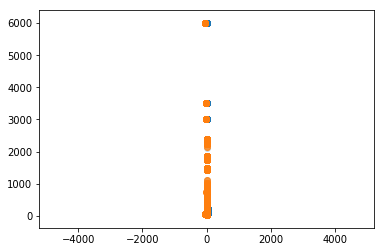

In [29]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

In [49]:
X_new = pca.inverse_transform(finalDf)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.2)
#plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

ValueError: shapes (400000,3) and (2,14) not aligned: 3 (dim 1) != 2 (dim 0)

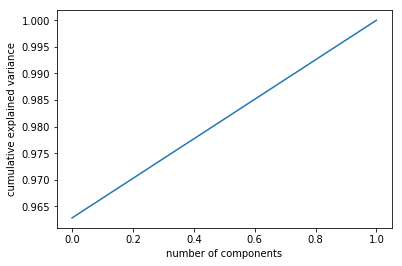

In [32]:
pca = PCA().fit(X_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [33]:
X

array([[ 2.00000000e+01,  3.75000000e+02,  3.85000000e+00, ...,
         2.99573227e+00,  2.01490302e+00,  3.33910035e-01],
       [ 8.00000000e+00,  5.00000000e+01,  8.75000000e+00, ...,
         0.00000000e+00, -2.99573227e+00,  3.33587205e-01],
       [ 1.20000000e+01,  1.00000000e+03,  1.65000000e+01, ...,
         1.79175947e+00,  1.79175947e+00,  3.33333333e-01],
       ...,
       [ 1.20000000e+01,  7.50000000e+02,  7.49000000e+00, ...,
         2.48490665e+00,  2.19722458e+00,  3.33629893e-01],
       [ 1.20000000e+01,  7.50000000e+02,  7.49000000e+00, ...,
         2.48490665e+00,  2.19722458e+00,  3.33629893e-01],
       [ 1.20000000e+01,  7.50000000e+02,  7.49000000e+00, ...,
         2.48490665e+00,  2.19722458e+00,  3.33629893e-01]])

In [35]:

import numpy as np
from sklearn import linear_model


# Fit (train) the Logistic Regression classifier
clf = linear_model.LogisticRegression(C=1e40, solver='newton-cg')
fitted_model = clf.fit(X_pca, y)

# Predict
prediction_result = clf.predict([(70,180)])

C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
prediction_result

array([0], dtype=int64)

In [38]:
clf

LogisticRegression(C=1e+40, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
fitted_model

LogisticRegression(C=1e+40, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [99]:
len(y[y==1])

41755

In [100]:
len(y[y==0])

358245

In [56]:
X

array([[ 2.00000000e+01,  3.75000000e+02,  3.85000000e+00, ...,
         2.99573227e+00,  2.01490302e+00,  3.33910035e-01],
       [ 8.00000000e+00,  5.00000000e+01,  8.75000000e+00, ...,
         0.00000000e+00, -2.99573227e+00,  3.33587205e-01],
       [ 1.20000000e+01,  1.00000000e+03,  1.65000000e+01, ...,
         1.79175947e+00,  1.79175947e+00,  3.33333333e-01],
       ...,
       [ 1.20000000e+01,  7.50000000e+02,  7.49000000e+00, ...,
         2.48490665e+00,  2.19722458e+00,  3.33629893e-01],
       [ 1.20000000e+01,  7.50000000e+02,  7.49000000e+00, ...,
         2.48490665e+00,  2.19722458e+00,  3.33629893e-01],
       [ 1.20000000e+01,  7.50000000e+02,  7.49000000e+00, ...,
         2.48490665e+00,  2.19722458e+00,  3.33629893e-01]])

In [57]:
# Split into train and test data.
train_data, train_labels = X[:7000], y[:7000]
test_data, test_labels = X[7000:], y[7000:]

In [58]:
### STUDENT START ###
def P1(n_components=50):
    # setting random_state to ensure consistent results
    pca = PCA(random_state=0)
    
    # fit the training data
    pca.fit(train_data)
    
    # grabbing the explained variance ratio (EVR) for each component
    evr = pca.explained_variance_ratio_
    n = np.arange(1,len(evr)+1)
    
    # display EVR and cumulative EVR for components in [1, n_components]
    df = pd.DataFrame(zip(n, evr, np.cumsum(evr)), columns=[
        'Component',
        'Component Explained Var. Ratio', 
        'Cumulative Explained Var. Ratio'
    ])
    df = df.set_index('Component')
    print(df.head(n_components))

P1()
### STUDENT END ###

           Component Explained Var. Ratio  Cumulative Explained Var. Ratio
Component                                                                 
1                            9.097261e-01                         0.909726
2                            5.942062e-02                         0.969147
3                            2.852222e-02                         0.997669
4                            1.205617e-03                         0.998875
5                            1.010579e-03                         0.999885
6                            8.182283e-05                         0.999967
7                            2.841414e-05                         0.999995
8                            4.445596e-06                         1.000000
9                            2.178219e-07                         1.000000
10                           7.953814e-10                         1.000000
11                           2.412948e-13                         1.000000
12                       

In [68]:
### STUDENT START ###
#def P2(data, labels):
fig = plt.figure(figsize=(10,10))
    
# setting my number of components to 2 for 2D projection
pca = PCA(n_components=2, random_state=0)
    
    # Fitting and the training data and projecting into 2 dimensions
x = pca.fit(train_data).transform(train_data)
#y = labels
#    return x
    
#train_data_2D = P2(train_data, train_labels)

<Figure size 720x720 with 0 Axes>

In [70]:
x

array([[-469.60587544,   22.15760871],
       [-826.9525878 ,   12.46240969],
       [ 150.47156835,  -13.88343381],
       ...,
       [-101.24271442,   -5.30360676],
       [ -99.50170502,   -4.88770909],
       [-100.38855825,   -5.10588809]])

ValueError: x and y must be the same size

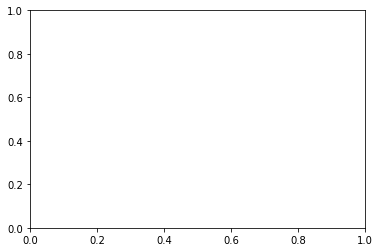

In [94]:
    # Plot the results with 'poisonous' in blue and 'non-poisonous' in 
    # red
    #plt.scatter(x[y == 1, 0], x[y == 1, 1], c='darkblue', alpha=0.8)
    plt.scatter(x[y[y == 1]], y[y == 1])
    #plt.scatter(x[y == 0, 0], x[y == 0, 1], c='darkred', alpha=0.8)
    
    plt.legend(['Poisonous', 'Non-poisonous'])
    plt.title('Mushroom Properties, Projected onto 2 Dimensions')
    

In [82]:
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [90]:
x[y[y == 1]]

array([[-826.9525878 ,   12.46240969],
       [-826.9525878 ,   12.46240969],
       [-826.9525878 ,   12.46240969],
       ...,
       [-826.9525878 ,   12.46240969],
       [-826.9525878 ,   12.46240969],
       [-826.9525878 ,   12.46240969]])

In [89]:
x[y[y == 0]]

array([[-469.60587544,   22.15760871],
       [-469.60587544,   22.15760871],
       [-469.60587544,   22.15760871],
       ...,
       [-469.60587544,   22.15760871],
       [-469.60587544,   22.15760871],
       [-469.60587544,   22.15760871]])

In [101]:
import numpy as np
from sklearn import linear_model


# Fit (train) the Logistic Regression classifier
clf = linear_model.LogisticRegression(C=1e40, solver='newton-cg')
fitted_model = clf.fit(x, y)

# Predict
prediction_result = clf.predict([(70,180)])

C:\ProgramData\Anaconda3\envs\ML7331\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Found input variables with inconsistent numbers of samples: [7000, 400000]